In [177]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline
from tkinter import *
from tkinter import messagebox
import smtplib

In [178]:
mails = pd.read_csv('spam.csv', encoding = 'latin-1')
mails.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [179]:
mails.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
mails.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [180]:
mails.rename(columns = {'v1': 'labels', 'v2': 'message'}, inplace = True)
mails.head()

,labels,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [181]:
mails['labels'].value_counts()

ham     4825
spam     747
Name: labels, dtype: int64

In [182]:
mails['label'] = mails['labels'].map({'ham': 0, 'spam': 1})
mails.head()

,labels,message,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [183]:
mails.drop(['labels'], axis = 1, inplace = True)
mails.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [184]:
trainIndex, testIndex = list(), list()
for i in range(mails.shape[0]):
    if np.random.uniform(0, 1) < 0.75:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = mails.loc[trainIndex]
testData = mails.loc[testIndex]

In [185]:
trainData.reset_index(inplace = True)
trainData.drop(['index'], axis = 1, inplace = True)
trainData.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Free entry in 2 a wkly comp to win FA Cup fina...,1
2,"Nah I don't think he goes to usf, he lives aro...",0
3,FreeMsg Hey there darling it's been 3 week's n...,1
4,Even my brother is not like to speak with me. ...,0


In [186]:
testData.reset_index(inplace = True)
testData.drop(['index'], axis = 1, inplace = True)
testData.head()


,message,label
0,Ok lar... Joking wif u oni...,0
1,U dun say so early hor... U c already then say...,0
2,I'm gonna be home soon and i don't want to tal...,0
3,England v Macedonia - dont miss the goals/team...,1
4,Is that seriously how you spell his name?,0


In [187]:
trainData['label'].value_counts()

0    3608
1     563
Name: label, dtype: int64

In [188]:
testData['label'].value_counts()

0    1217
1     184
Name: label, dtype: int64

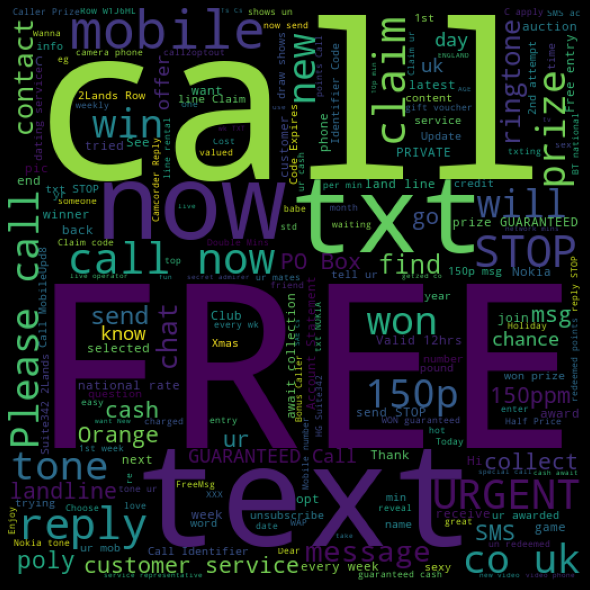

In [189]:
spam_words = ' '.join(list(mails[mails['label'] == 1]['message']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

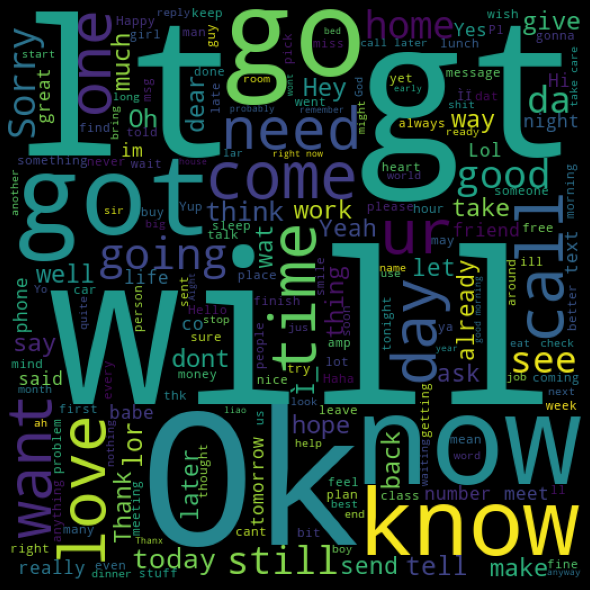

In [190]:
ham_words = ' '.join(list(mails[mails['label'] == 0]['message']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [191]:
trainData.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Free entry in 2 a wkly comp to win FA Cup fina...,1
2,"Nah I don't think he goes to usf, he lives aro...",0
3,FreeMsg Hey there darling it's been 3 week's n...,1
4,Even my brother is not like to speak with me. ...,0


In [192]:
trainData['label'].value_counts()

0    3608
1     563
Name: label, dtype: int64

In [193]:
testData.head()

,message,label
0,Ok lar... Joking wif u oni...,0
1,U dun say so early hor... U c already then say...,0
2,I'm gonna be home soon and i don't want to tal...,0
3,England v Macedonia - dont miss the goals/team...,1
4,Is that seriously how you spell his name?,0


In [194]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words


In [195]:
class SpamClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.mails, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + \
                                            len(list(self.tf_spam.keys())))
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + \
                                                                len(list(self.tf_ham.keys())))
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 


    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.mails[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels[i]:
                    self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                    self.spam_words += 1
                else:
                    self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                    self.ham_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels[i]:
                    self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                else:
                    self.idf_ham[word] = self.idf_ham.get(word, 0) + 1
    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham.get(word, 0)))
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam.get(word, 0) + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
                    
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                if self.method == 'tf-idf':
                    pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                else:
                    pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                if self.method == 'tf-idf':
                    pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                else:
                    pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam >= pHam
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [196]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [197]:
'''sc_tf_idf = SpamClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['message'])
metrics(testData['label'], preds_tf_idf)'''

"sc_tf_idf = SpamClassifier(trainData, 'tf-idf')\nsc_tf_idf.train()\npreds_tf_idf = sc_tf_idf.predict(testData['message'])\nmetrics(testData['label'], preds_tf_idf)"

In [198]:
'''sc_bow = SpamClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['message'])
metrics(testData['label'], preds_bow)'''

"sc_bow = SpamClassifier(trainData, 'bow')\nsc_bow.train()\npreds_bow = sc_bow.predict(testData['message'])\nmetrics(testData['label'], preds_bow)"

In [199]:
pm = process_message('I cant pick the phone right now. Pls send a message')
sc_tf_idf.classify(pm)

False

In [200]:
pm = process_message('Congratulations ur awarded $500 ')
sc_tf_idf.classify(pm)

True

In [201]:
window = Tk()
window.geometry("600x550")
window.title("EMAIL CLIENT")
window.resizable(0, 0)
window.config(bg='light blue')

labeltitle= Label(window, text="EMAIL CLIENT",bg='light blue',fg='black', justify='center',
               font=('Times New Roman', 20, "bold")).place(x=200 , y=20)
#Label
labelUser = Label(window, text="Sender's Email", fg='black', bg='light blue',
                  font=('Times New Roman', 18)).place(x=65, y=90)
labelpass = Label(window, text="Password", fg='black', bg='light blue',
                  font=('Times New Roman', 18)).place(x=65, y=155)
labelremail = Label(window, text="Receiver's Email", fg='black', bg='light blue',
                  font=('Times New Roman', 18)).place(x=65, y=220)
labelsubject = Label(window, text="Subject", fg='black', bg='light blue',
                  font=('Times New Roman', 18)).place(x=65, y=285)
labelMessage = Label(window, text="Message", fg='black', bg='light blue',
                  font=('Times New Roman', 18)).place(x=65, y=350)
#Entry
entryUser = Entry(window, fg='black', bg='light blue',
                  font=('Times New Roman', 15), relief='sunken')
entryUser.place(x=300, y=90)
entryPass = Entry(window, fg='black', bg='light blue', show="X",
                  font=('Times New Roman', 15), relief='sunken')
entryPass.place(x=300, y=155)
entryRemail = Entry(window, fg='black', bg='light blue',
                  font=('Times New Roman', 15), relief='sunken')
entryRemail.place(x=300, y=220)
entrySubject = Entry(window, fg='black', bg='light blue',
                  font=('Times New Roman', 15), relief='sunken')
entrySubject.place(x=300, y=285)
entryMessage = Entry(window, fg='black', bg='light blue',
                  font=('Times New Roman', 15), relief='sunken')
entryMessage.place(x=300, y=350)

def send():
    username=entryUser.get()
    password=entryPass.get()
    remail=entryRemail.get()
    subject=entrySubject.get()
    message=entryMessage.get()
    if username=="" or password=="" or remail=="" or subject=="" or message=="":
        messagebox.showwarning(title="Email Client",message="Fill all the Fields Correctly")
    else:
        finalmessage='Subject:{}\n\n{}'.format(subject,message)
        server=smtplib.SMTP('smtp.gmail.com',587)
        server.starttls()
        server.login(username,password)
        server.sendmail(username,remail,finalmessage)
        server.quit()
        messagebox.showinfo(title='Email Client',message='Email Sent Successfully')

           


def reset():
    entryUser.delete(0,'end')
    entryPass.delete(0,'end')
    entryRemail.delete(0,'end')
    entrySubject.delete(0,'end')
    entryMessage.delete(0,'end')

def pre():
    pm = process_message(entryMessage.get())
    print(entryMessage.get())
    t= sc_tf_idf.classify(pm)
    print(t)
    if t:
        messagebox.showwarning(title='Email Client', message='    SPAM    ')
    else:
        messagebox.showwarning(title='Email Client', message='    HAM    ')

#buttons
buttonSend = Button(window,text='Send Mail', fg='black', bg='light blue',
                  font=('Times New Roman', 18),command=send)
buttonSend.place(x=90, y=450)

buttonReset = Button(window,text='   Reset   ', fg='black', bg='light blue',
                     font=('Times New Roman',18),command=reset)
buttonReset.place(x=239, y=450)


buttonPredict = Button(window,text='   Predict   ', fg='black', bg='light blue',
                     font=('Times New Roman',18),command=pre)
buttonPredict.place(x=380, y=450)
window.mainloop()

hello
True
